Universidade Estadual de Campinas - UNICAMP

Faculdade de Engenharia Elétrica e de Computação - FEEC

### IA048 – Aprendizado de Máquina

Alunos:
* Tiago Corrêa de Araújo de Amorim (RA: 100.675)
* Taylon L C Martins (RA: 177.379)

# Lista 02

## Tarefa

Abordar o problema de reconhecimento de atividades humanas (HAR, do inglês _human activity recognition_) a partir de informações capturadas por sensores de smartphones.

Utilizar regressão logística e kNN, com os dados pré-processados e dados brutos.

**Dataset**

* [UCI HAR](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)

* Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

In [126]:
# Import modules

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# from sklearn.metrics import multilabel_confusion_matrix
# from sklearn.metrics import balanced_accuracy_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import log_loss
# from sklearn.metrics import precision_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# from matplotlib.dates import DateFormatter
# from matplotlib.patches import Patch

In [2]:
# Define if will rerun models
RERUN = False

## Common Functions

In [87]:
# Read csv function with options
def read_csv_(path, sep=r"\s+|;|:|,"):
    return pd.read_csv(filepath_or_buffer=path, sep=sep, engine="python", header=None)

In [86]:
# Function to perform a 5-fold Cross-validation
def do_CV(X, y, model, n_splits=5, verbose=False, retrain_all=False):
    skf = StratifiedKFold(n_splits=n_splits)
    recall = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        if verbose:
            print(f"Split {i}: balanced accuracy={balanced_accuracy}")
        recall.append(balanced_accuracy)
    if retrain_all:
        model.fit(X, y)
    return np.mean(recall)

In [ ]:
# Function to summarize results
def print_table(data, horizontal_lines=[1]):
    column_widths = [max(len(str(item)) for item in column)
                     for column in zip(*data)]
    format_string = " | ".join(f"{{:<{width}}}" for width in column_widths)
    for i, row in enumerate(data):
        if i in horizontal_lines:
            print("-" * len("| " + format_string.format(*row) + " |"))
        print("| " + format_string.format(*row) + " |")


def model_summary(model, X_test, y_test, labels, description, filename):

    def _model_summary_table(y_pred, y_test, labels):
        results = [("Class", "Recall", "F1 score")]
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        f1_macro = f1_score(y_test, y_pred, average="macro")
        results.append(
            ("All", f"{balanced_accuracy:0.4f}", f"{f1_macro:0.4f}"))
        recall = recall_score(y_test, y_pred, average=None)
        f1 = f1_score(y_test, y_pred, average=None)
        for label, r, f1 in zip(labels, recall, f1):
            results.append((label, f"{r:0.4f}", f"{f1:0.4f}"))
        print_table(results, horizontal_lines=[1, 2])


    def _model_summary_confusion_matrix(y_test, y_pred, labels, description, filename):
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_disp = ConfusionMatrixDisplay(
            confusion_matrix=conf_matrix, display_labels=labels
        )
        fig, ax = plt.subplots(figsize=(8, 6))
        plt.title(f"{description} Confusion Matrix")
        conf_matrix_disp.plot(ax=ax, xticks_rotation=40)
        plt.savefig(f"report/png/{filename}", bbox_inches="tight")
        plt.show()


    y_pred = model.predict(X_test)
    _model_summary_table(y_pred, y_test, labels)
    _model_summary_confusion_matrix(
        y_pred, y_test, labels, description, filename)

## Preprocessed Dataset

In [4]:
# Get label names
df_labels = read_csv_(r"..\Lista02\UCI_HAR_Dataset\activity_labels.txt")
df_labels.drop(0, axis=1, inplace=True)
df_labels = df_labels.rename(columns={1: "activity"})
labels = df_labels["activity"].values


def get_label_name(i):
    return df_labels["activity"][i - 1]

In [6]:
# Get feature names
df_features = read_csv_(r"..\Lista02\UCI_HAR_Dataset\features.txt", sep=r"\s+")
df_features.drop(0, axis=1, inplace=True)
df_features = df_features.rename(columns={1: "feature"})
features = df_features["feature"].values


def get_feature_name(i):
    return df_features["feature"][i]

In [5]:
# Read preprocessed data
X = read_csv_(r"..\Lista02\UCI_HAR_Dataset\train\X_train.txt")
y = read_csv_(r"..\Lista02\UCI_HAR_Dataset\train\y_train.txt")
X_test = read_csv_(r"..\Lista02\UCI_HAR_Dataset\test\X_test.txt")
y_test = read_csv_(r"..\Lista02\UCI_HAR_Dataset\test\y_test.txt")

print("Train data")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")
print("Test data")
print(f"  X: {X_test.shape}")
print(f"  y: {y_test.shape}")

Train data
  X: (7352, 561)
  y: (7352, 1)
Test data
  X: (2947, 561)
  y: (2947, 1)


In [7]:
# Count labels
train_labels = y[0].unique()
train_labels.sort()
train_label_count = [len(y[0][y[0] == label]) for label in train_labels]

test_labels = y_test[0].unique()
test_labels.sort()
test_label_count = [len(y_test[0][y_test[0] == label]) for label in test_labels]

print(f"Labels are the same: {np.all(test_labels == train_labels)}")
max_labels_ratio = min(train_label_count) / max(train_label_count)
print(f"Smallest/Largest train labels: {max_labels_ratio*100:0.2f}%")

Labels are the same: True
Smallest/Largest train labels: 70.08%


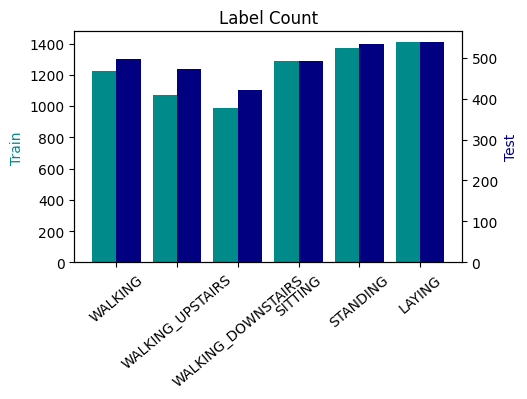

In [8]:
# Build label count plot
fig, ax1 = plt.subplots(figsize=(5, 3))
ax2 = ax1.twinx()

ax1.bar(
    np.arange(len(labels)) - 0.2,
    train_label_count,
    color="darkcyan",
    width=0.4,
    align="center",
)
ax1.set_ylabel("Train", color="darkcyan")

ax2.bar(
    np.arange(len(labels)) + 0.2,
    test_label_count,
    color="navy",
    width=0.4,
    align="center",
)
ax2.set_ylabel("Test", color="navy")

plt.title("Label Count")
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels, rotation=40)
plt.savefig("report/png/A_LabelCount.png", bbox_inches="tight")
plt.show()

Aparentemente o desbalanço entre as classes não é significativo (menor classe tem 30% menos elementos que a maior classe), mas existe. De toda forma será utilizada a acurácia balanceada como métrica da qualidade do classificador (média dos _recalls_ de cada classe).

In [9]:
# Check data
X.describe()


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


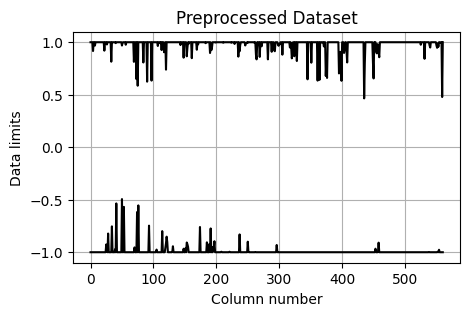

In [108]:
plt.figure(figsize=(5, 3))
plt.plot(X.max(), color="black")
plt.plot(X.min(), color="black")

plt.xlabel("Column number")
plt.ylabel("Data limits")
plt.title("Preprocessed Dataset")
plt.grid(True)
plt.savefig(r"report/png/A_Dataset_Scale", bbox_inches="tight")
plt.show()

Dados estão normalizados em [-1;1], com algumas poucas exceções. Os testes seguirão com os dados originais.

### Logistic Regression

Opções utilizadas:

* Validação cruzada estratificada em 5 pastas.
* Normalização $l_2$ ($\frac{1}{2} ||w||_2^2$), com otimização do seu inverso ($c = \frac{1}{l_2}$)
* Função objetivo da otimização: acurácia balanceada.
* Estratégia: multinomial (entropia cruzada).

Fontes: 

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

* https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [36]:
# Build logistic model
if RERUN:
    logistic = LogisticRegressionCV(
        cv=5, solver="saga", scoring="balanced_accuracy", random_state=42, n_jobs=-1
    )
    logistic.fit(X, y[0].values)
    _ = joblib.dump(logistic, "logistic_model.sav")
else:
    logistic = joblib.load("logistic_model.sav")

print(f"Normalization coefficients l2:\n {
      [np.round(1/c, 4) for c in logistic.C_]}")

balanced_accuracy = {}
balanced_accuracy[("logistic","CV")] = logistic.score(X, y[0].values)
print(f"Logistic CV balanced accuracy = {balanced_accuracy[("logistic","CV")]:0.4f}")
y_pred = logistic.predict(X_test)
balanced_accuracy[("logistic","Test")] = recall_score(y_test, y_pred, average="macro")


Logistic CV balanced accuracy = 0.9932
Normalization coefficients l2:
 [0.3594, 0.3594, 0.3594, 0.3594, 0.3594, 0.3594]


| Class              | Recall | F1 score |
------------------------------------------
| All                | 0.9598 | 0.9606   |
------------------------------------------
| WALKING            | 0.9940 | 0.9686   |
| WALKING_UPSTAIRS   | 0.9427 | 0.9569   |
| WALKING_DOWNSTAIRS | 0.9690 | 0.9795   |
| SITTING            | 0.8717 | 0.9214   |
| STANDING           | 0.9812 | 0.9372   |
| LAYING             | 1.0000 | 1.0000   |


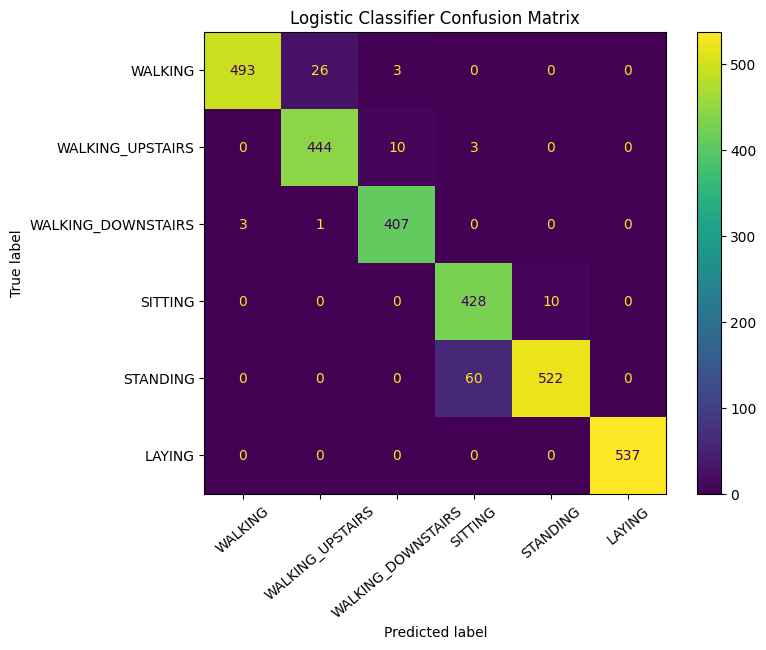

In [25]:
# Summarize logistic model
model_summary(
    model=logistic,
    X_test=X_test,
    y_test=y_test,
    labels=labels,
    description="Logistic Classifier",
    filename="A_Logistic_CM.png",
)

O F1-score também seria uma boa escolha para avaliar a qualidade dos classificadores.

Em geral o classificador tem um bom desempenho. Ao analisar por classe, fica claro que o desempenho não é uniforme. A classe 'SITTING' tem um valor de recall bem mais baixo que as demais.

### kNN

Primeira tentativa de construção de um classificador com kNN utilizou as opções _padrão_ da implementação do Scikit-Learn.

In [21]:
# Function to optimize k in a kNN classifier
def find_knn_best_k(
    X, y, model, k_range, plot_filename=None, verbose=False, details=False
):
    results = []
    for k in k_range:
        model.set_params(n_neighbors=k)
        bal_acc = do_CV(X=X, y=y[0], model=model, verbose=details)
        if verbose:
            print(f"k={k}: balanced_accuracy = {bal_acc:0.4f}")
        results.append(bal_acc)

    best_i = results.index(max(results))
    best_k = k_range[best_i]
    if verbose:
        print(f"Best k={best_k}")
        print(f"Balanced accuracy = {results[best_i]:0.4f}")

    model.set_params(n_neighbors=best_k)
    model.fit(X, y[0])

    if plot_filename is not None:
        plt.figure(figsize=(5, 3))
        plt.plot(k_range, results, color="black", marker="o")
        plt.plot(best_k, results[best_i], color="red", marker="o", label="Best")

        plt.xlabel("k")
        plt.ylabel("Recall")
        plt.title("k-Nearest Neighbours")
        plt.grid(True)
        plt.legend()
        plt.savefig(f"report/png/{plot_filename}", bbox_inches="tight")
        plt.show()

    return model, best_k, results[best_i]

In [40]:
# Build vanilla kNN
print("Vanilla kNN")

if RERUN:
    knn_vanilla = KNeighborsClassifier()
    results = find_knn_best_k(
        X=X,
        y=y,
        model=knn_vanilla,
        k_range=range(1, 30),
        plot_filename="A_kNN_bestK.png",
        verbose=True,
    )
    knn_vanilla, best_k, balanced_accuracy[("knn vanilla","CV")] = results

    _ = joblib.dump(knn_vanilla, "knn_vanilla_model.sav")
else:
    knn_vanilla = joblib.load("knn_vanilla_model.sav")
    best_k = knn_vanilla.get_params()["n_neighbors"]
    print(f"Best k = {best_k}")
    balanced_accuracy[("knn vanilla","CV")] = do_CV(
        X=X,
        y=y[0],
        model=knn_vanilla,
        retrain_all=True)
    print(f"Balanced accuracy = {balanced_accuracy[("knn vanilla","CV")]:0.4f}")

y_pred = knn_vanilla.predict(X_test)
balanced_accuracy[("knn vanilla","Test")] = recall_score(y_test, y_pred, average="macro")

Vanilla kNN
Best k = 17


Balanced accuracy = 0.8999


| Class              | Recall | F1 score |
------------------------------------------
| All                | 0.8903 | 0.8919   |
------------------------------------------
| WALKING            | 0.9879 | 0.9133   |
| WALKING_UPSTAIRS   | 0.9321 | 0.9033   |
| WALKING_DOWNSTAIRS | 0.7310 | 0.8365   |
| SITTING            | 0.7719 | 0.8339   |
| STANDING           | 0.9305 | 0.8699   |
| LAYING             | 0.9888 | 0.9944   |


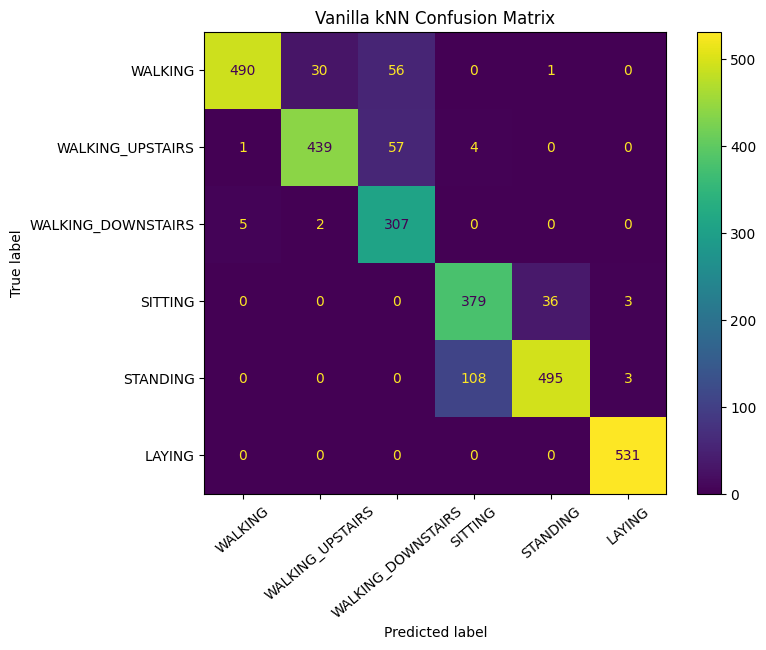

In [19]:
# Summarize Vanilla kNN
model_summary(
    model=knn_vanilla,
    X_test=X_test,
    y_test=y_test,
    labels=labels,
    description="Vanilla kNN",
    filename="A_kNN_Vanilla_CM",
)

Foi feita uma busca em grade ao redor do melhor k encontrado, buscando os melhores hiperparâmetros para o classificador de k-vizinhos mais próximos. 

In [50]:
print("Optimized hyperparameters")
if RERUN:
    param_grid = {
        "n_neighbors": np.arange(best_k - 1, best_k + 2),
        "weights": ["uniform", "distance"],
        "p": [1, 2],
    }

    knn_opt1 = KNeighborsClassifier()
    grid_search = GridSearchCV(
        estimator=knn_opt1,
        param_grid=param_grid,
        cv=3,
        scoring="balanced_accuracy",
        n_jobs=-1,
    )

    grid_search.fit(X, y[0].values)
    best_params = grid_search.best_params_

    _ = joblib.dump(knn_opt1, "knn_opt1_model.sav")
else:
    knn_opt1 = joblib.load("knn_opt1_model.sav")

print(f"Best hyperparameters={best_params}")
balanced_accuracy[("knn opt1","CV")] = do_CV(X=X, y=y[0], model=knn_opt1, retrain_all=True)
print(f"Balanced accuracy = {balanced_accuracy[("knn opt1","CV")]:0.4f}")
y_pred = knn_opt1.predict(X_test)
balanced_accuracy[("knn opt1","Test")] = recall_score(y_test, y_pred, average="macro")

Optimized hyperparameters
Best hyperparameters={'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
Balanced accuracy = 0.9045


| Class              | Recall | F1 score |
------------------------------------------
| All                | 0.9146 | 0.9165   |
------------------------------------------
| WALKING            | 0.9859 | 0.9200   |
| WALKING_UPSTAIRS   | 0.9108 | 0.8966   |
| WALKING_DOWNSTAIRS | 0.7786 | 0.8651   |
| SITTING            | 0.8330 | 0.8979   |
| STANDING           | 0.9793 | 0.9197   |
| LAYING             | 1.0000 | 1.0000   |


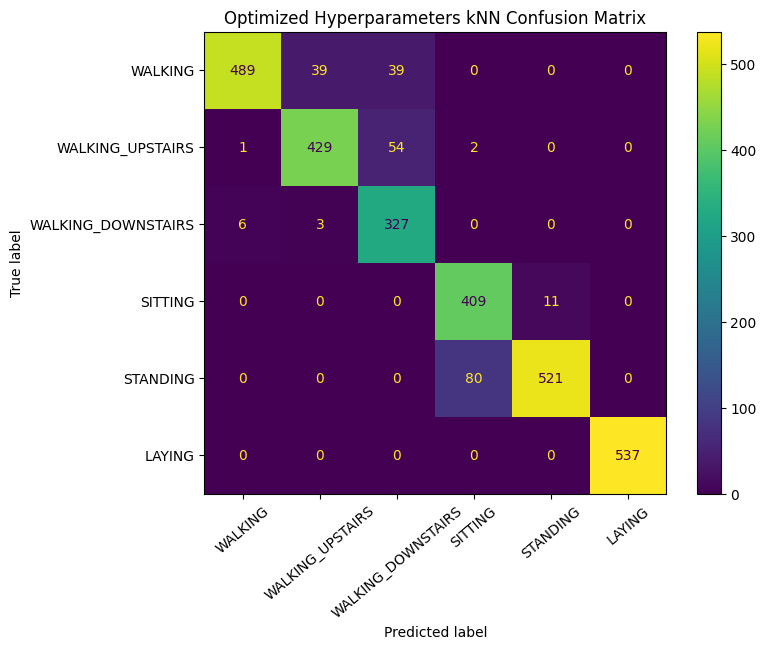

In [61]:
model_summary(
    model=knn_opt1,
    X_test=X_test,
    y_test=y_test,
    labels=labels,
    description="Optimized Hyperparameters kNN",
    filename="A_kNN_opt1_CM.png",
)

Resultado do classificador kNN ficou abaixo do logístico. Os valores de acurácia balanceada já indicavam este comportamento. Nesta primeira tentativa apenas o valor de K, p e critério de pesos foram avaliados. Uma nova tentativa será feita aplicando normalização [0,1] a todos os dados.

In [84]:
# Build model with features scaled [0;1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_data, columns=X.columns)

print("[0;1] Scaled X kNN")

if RERUN:
    knn_scaled = KNeighborsClassifier(**best_params)
    knn_scaled.fit(X_scaled, y[0].values)
    _ = joblib.dump(knn_scaled, "knn_scaled_model.sav")
else:
    knn_scaled = joblib.load("knn_scaled_model.sav")

balanced_accuracy[("knn scaled","CV")] = do_CV(
    X=X_scaled,
    y=y[0],
    model=knn_scaled,
    retrain_all=True)
print(f"Balanced accuracy = {balanced_accuracy[("knn scaled","CV")]:0.4f}")
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
y_pred = knn_scaled.predict(X_test_scaled)
balanced_accuracy[("knn scaled","Test")] = recall_score(y_test, y_pred, average="macro")

[0;1] Scaled X kNN
Balanced accuracy = 0.9059


| Class              | Recall | F1 score |
------------------------------------------
| All                | 0.9153 | 0.9173   |
------------------------------------------
| WALKING            | 0.9859 | 0.9209   |
| WALKING_UPSTAIRS   | 0.9151 | 0.8989   |
| WALKING_DOWNSTAIRS | 0.7786 | 0.8662   |
| SITTING            | 0.8350 | 0.8981   |
| STANDING           | 0.9793 | 0.9205   |
| LAYING             | 0.9981 | 0.9991   |


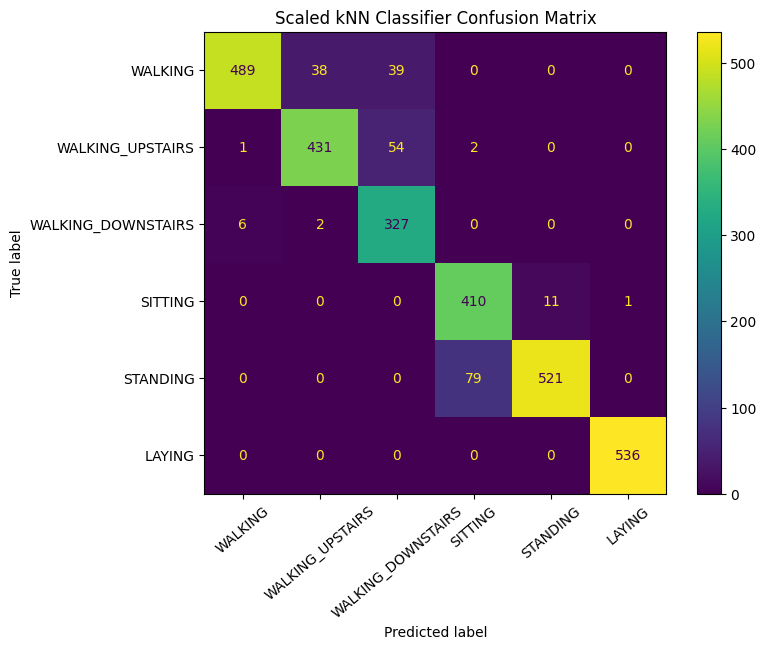

In [59]:
model_summary(
    model = knn_scaled,
    X_test = scaler.transform(X_test),
    y_test=y_test,
    labels=labels,
    description="Scaled kNN Classifier",
    filename="A_kNN_Scaled_CM.png"
)

Aplicar uma escala [0;1] nos dados de entrada levou a uma pequena melhora na acuária balanceada.

A última etapa na busca por um classificador kNN de melhores resultados é testando os parâmetros de entrada. É feita uma otimização _gulosa_ dos parâmetros que devem ser utilizados na construção do classificador de k-vizinhos mais próximos. 

A cada iteração são avaliados todos os parâmetros de entrada. É feito um teste retirando um dos parâmetros de entrada. O modelo kNN é reconstruído e se a acurácia balanceada aumentar, este parâmetro é retirado permamentemente. O algoritmo para quando nenhum parâmetro for retirado em uma iteração. 

In [78]:
def filtered_df(df, boolean_list):
    columns_to_select = {column: value for column, value in zip(df.keys(), boolean_list) if value}
    return pd.DataFrame(df)[columns_to_select.keys()]

def trim_columns_model(X, y, model, n_splits=2, max_iterations=10, shuffle=True):
    changes = 99
    iterations = 0
    columns = list(range(len(X.columns)))
    keep = [True] * len(X.columns)
    best_ba = do_CV(X=X, y=y[0], model=model, n_splits=n_splits)
    print(f"Iteration 0: Columns = {keep.count(True)}, Balanced Accuracy = {best_ba:0.4f}")
    while changes > 0 and iterations < max_iterations:
        iterations += 1
        changes = 0
        if shuffle:
            random.shuffle(columns)
        for i in columns:
            if keep[i]:
                keep_try = keep.copy()
                keep_try[i] = False
                X_new = filtered_df(X, keep_try)
                new_ba = do_CV(X=X_new, y=y[0], model=model, n_splits=n_splits)
                if new_ba >= best_ba:
                    best_ba = new_ba
                    keep = keep_try
                    changes += 1
        print(f"Iteration {i}: Columns = {keep.count(True)}, Balanced Accuracy = {best_ba:0.4f}")
    return keep

In [83]:
knn_opt2 = KNeighborsClassifier(**best_params)
if RERUN:
    columns_keep = trim_columns_model(
        model=knn_opt2,
        X=X_scaled,
        y=y,
        max_iterations=1,
        n_splits=5)
    joblib.dump(columns_keep, "knn_trim_columns.sav")
else:
    columns_keep = joblib.load("knn_trim_columns.sav")

X_trim = filtered_df(X_scaled, columns_keep)
balanced_accuracy[("knn trimmed","CV")] = do_CV(
    X=X_trim,
    y=y[0],
    model=knn_opt2,
    retrain_all=True)
print(f"Balanced accuracy = {balanced_accuracy[("knn trimmed","CV")]:0.4f}")
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
y_pred = knn_opt2.predict(filtered_df(X_test_scaled, columns_keep))
balanced_accuracy[("knn trimmed","Test")] = recall_score(y_test, y_pred, average="macro")

Balanced accuracy = 0.9073


O modelo de k-vizinhos mais próximos tem poucos parâmetros para ajuste. Foi possível melhorar os resultados com relação a otimizar apenas o número de vizinhos, mas o incremento foi relativamente pequeno. Os resultados com os dados de teste geralmente seguiram os incrementos nos resultados com a validação cruzada, mas nem em todos os testes. Em todas as tentativas os resultados ficaram abaixo daqueles do classificador logístico. 

## Raw Dataset

In [104]:
# Read raw data

folder = r"..\Lista02\UCI_HAR_Dataset\train\Inertial Signals"
signals = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
]

folder = r"..\Lista02\UCI_HAR_Dataset\train\Inertial Signals"
X_raw = read_csv_(f"{folder}\\{signals[0]}_train.txt")
for s in signals[1:]:
    X_raw_new = read_csv_(f"{folder}\\{s}_train.txt")
    X_raw = pd.concat([X_raw, X_raw_new], axis=1)
X_raw = X_raw.set_axis(range(len(X_raw.columns)), axis=1)

folder = r"..\Lista02\UCI_HAR_Dataset\test\Inertial Signals"
X_raw_test = read_csv_(f"{folder}\\{signals[0]}_test.txt")
for s in signals[1:]:
    X_raw_test_new = read_csv_(f"{folder}\\{s}_test.txt")
    X_raw_test = pd.concat([X_raw_test, X_raw_test_new], axis=1)
X_raw_test = X_raw_test.set_axis(range(len(X_raw_test.columns)), axis=1)

print("Train data")
print(f"  X: {X_raw.shape}")
print(f"  y: {y.shape}")
print("Test data")
print(f"  X: {X_raw_test.shape}")
print(f"  y: {y_test.shape}")

Train data
  X: (7352, 768)
  y: (7352, 1)
Test data
  X: (2947, 768)
  y: (2947, 1)


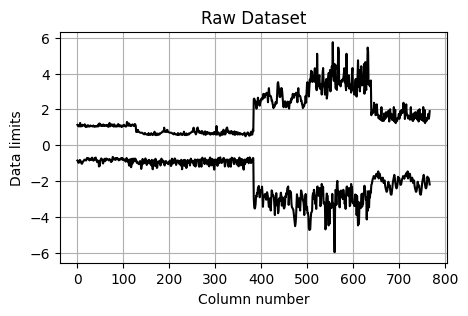

In [107]:
# Check raw data
plt.figure(figsize=(5, 3))
plt.plot(X_raw.max(), color="black")
plt.plot(X_raw.min(), color="black")

plt.xlabel("Column number")
plt.ylabel("Data limits")
plt.title("Raw Dataset")
plt.grid(True)
plt.savefig(r"report/png/B_Dataset_Scale", bbox_inches="tight")
plt.show()

Os dados não estão normalizados. Os dados pré-processados estavam em [-1;1] e foi pequeno o efeito de mudar a escala para [0;1]. Os dados brutos serão escalados para [-1;1].

In [112]:
# Build features scaled [-1;1]
scaler_raw = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler_raw.fit_transform(X_raw)
X_raw_scaled = pd.DataFrame(scaled_data, columns=X_raw.columns)

scaled_data = scaler_raw.transform(X_raw_test)
X_raw_scaled_test = pd.DataFrame(scaled_data, columns=X_raw_test.columns)

### Logistic Regression

In [119]:
# Build logistic model
if RERUN:
    logistic_raw = LogisticRegressionCV(
        cv=5, solver="saga", scoring="balanced_accuracy", random_state=42, n_jobs=-1
    )
    logistic_raw.fit(X_raw_scaled, y[0].values)
    _ = joblib.dump(logistic_raw, "logistic_raw_model.sav")
else:
    logistic = joblib.load("logistic_raw_model.sav")

print(f"Normalization coefficients l2:\n {
      [np.round(1/c, 4) for c in logistic_raw.C_]}")

balanced_accuracy[("logistic raw","CV")] = logistic_raw.score(X_raw_scaled, y[0].values)
print(f"Logistic CV balanced accuracy = {balanced_accuracy[("logistic raw","CV")]:0.4f}")
y_pred = logistic_raw.predict(X_raw_scaled_test)
balanced_accuracy[("logistic raw","Test")] = recall_score(y_test, y_pred, average="macro")


Normalization coefficients l2:
 [21.5443, 21.5443, 21.5443, 21.5443, 21.5443, 21.5443]
Logistic CV balanced accuracy = 0.3911


| Class              | Recall | F1 score |
------------------------------------------
| All                | 0.2999 | 0.2957   |
------------------------------------------
| WALKING            | 0.2560 | 0.3409   |
| WALKING_UPSTAIRS   | 0.2527 | 0.3434   |
| WALKING_DOWNSTAIRS | 0.2881 | 0.3523   |
| SITTING            | 0.0754 | 0.1054   |
| STANDING           | 0.6015 | 0.3760   |
| LAYING             | 0.3259 | 0.2564   |


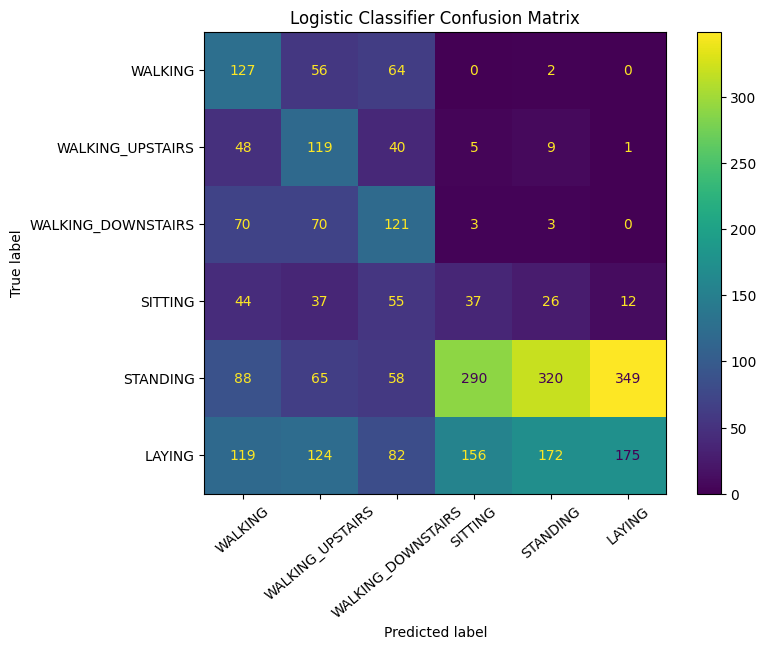

In [122]:
# Summarize logistic model
model_summary(
    model=logistic_raw,
    X_test=X_raw_scaled_test,
    y_test=y_test,
    labels=labels,
    description="Logistic Classifier",
    filename="B_Logistic_CM.png",
)

### kNN

Na primeira avaliação os ganhos com cálculos adicionais foram pequenos.

Vanilla kNN


k=1: balanced_accuracy = 0.7424
k=2: balanced_accuracy = 0.7170
k=3: balanced_accuracy = 0.7322
k=4: balanced_accuracy = 0.7090
k=5: balanced_accuracy = 0.7125
k=6: balanced_accuracy = 0.6999
k=7: balanced_accuracy = 0.6974
k=8: balanced_accuracy = 0.6837
k=9: balanced_accuracy = 0.6831
k=10: balanced_accuracy = 0.6668
k=11: balanced_accuracy = 0.6643
k=12: balanced_accuracy = 0.6515
k=13: balanced_accuracy = 0.6465
k=14: balanced_accuracy = 0.6379
k=15: balanced_accuracy = 0.6260
k=16: balanced_accuracy = 0.6194
k=17: balanced_accuracy = 0.6151
k=18: balanced_accuracy = 0.6038
k=19: balanced_accuracy = 0.5930
k=20: balanced_accuracy = 0.5842
k=21: balanced_accuracy = 0.5814
k=22: balanced_accuracy = 0.5718
k=23: balanced_accuracy = 0.5662
k=24: balanced_accuracy = 0.5581
k=25: balanced_accuracy = 0.5521
k=26: balanced_accuracy = 0.5433
k=27: balanced_accuracy = 0.5366
k=28: balanced_accuracy = 0.5306
k=29: balanced_accuracy = 0.5258
Best k=1
Balanced accuracy = 0.7424


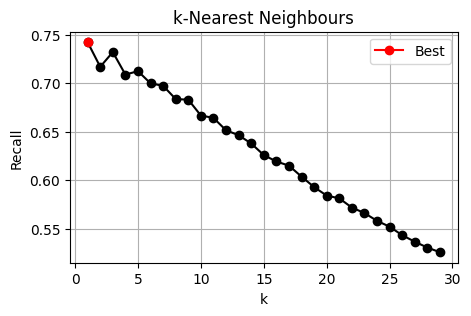

In [123]:
# Build vanilla kNN
print("Vanilla kNN")

if not RERUN:
    knn_raw_vanilla = KNeighborsClassifier()
    results = find_knn_best_k(
        X=X_raw_scaled,
        y=y,
        model=knn_raw_vanilla,
        k_range=range(1, 30),
        plot_filename="B_kNN_bestK.png",
        verbose=True,
    )
    knn_raw_vanilla, best_k_raw, balanced_accuracy[("knn raw vanilla","CV")] = results

    _ = joblib.dump(knn_vanilla, "knn_raw_vanilla_model.sav")
else:
    knn_raw_vanilla = joblib.load("knn_raw_vanilla_model.sav")
    best_k_raw = knn_raw_vanilla.get_params()["n_neighbors"]
    print(f"Best k = {best_k_raw}")
    balanced_accuracy[("knn raw vanilla","CV")] = do_CV(
        X=X_raw_scaled,
        y=y[0],
        model=knn_raw_vanilla,
        retrain_all=True)
    print(f"Balanced accuracy = {balanced_accuracy[("knn raw vanilla","CV")]:0.4f}")

y_pred = knn_raw_vanilla.predict(X_raw_scaled_test)
balanced_accuracy[("knn raw vanilla","Test")] = recall_score(y_test, y_pred, average="macro")

| Class              | Recall | F1 score |
------------------------------------------
| All                | 0.7191 | 0.7352   |
------------------------------------------
| WALKING            | 0.8427 | 0.8875   |
| WALKING_UPSTAIRS   | 0.8450 | 0.9108   |
| WALKING_DOWNSTAIRS | 0.6452 | 0.7844   |
| SITTING            | 0.7026 | 0.5862   |
| STANDING           | 0.5846 | 0.5466   |
| LAYING             | 0.6946 | 0.6959   |


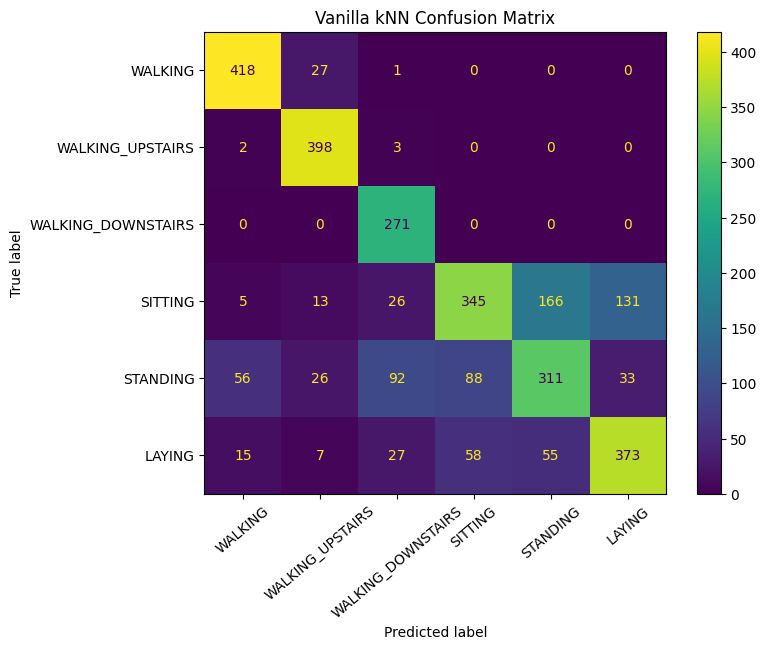

In [124]:
# Summarize Vanilla kNN
model_summary(
    model=knn_raw_vanilla,
    X_test=X_raw_scaled_test,
    y_test=y_test,
    labels=labels,
    description="Vanilla kNN",
    filename="B_kNN_Vanilla_CM",
)

In [125]:
balanced_accuracy

{('logistic raw', 'CV'): 0.39106626284947693,
 ('logistic raw', 'Test'): 0.2999237119406543,
 ('knn raw vanilla', 'CV'): 0.7423657860235012,
 ('knn raw vanilla', 'Test'): 0.7191373996667157}

### Visualize data

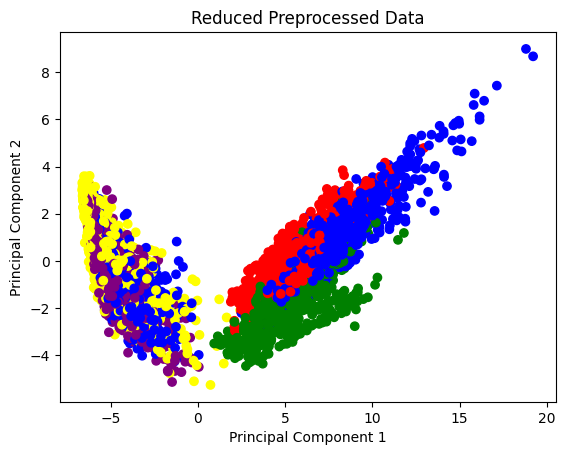

In [137]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

color_map = {label: color for label, color in zip(range(1,len(labels)+1), ["red", "green", "blue", "purple", "blue", "yellow"])}
colors = [color_map.get(label) for label in y[0]]

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=colors)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Reduced Preprocessed Data")
plt.show()

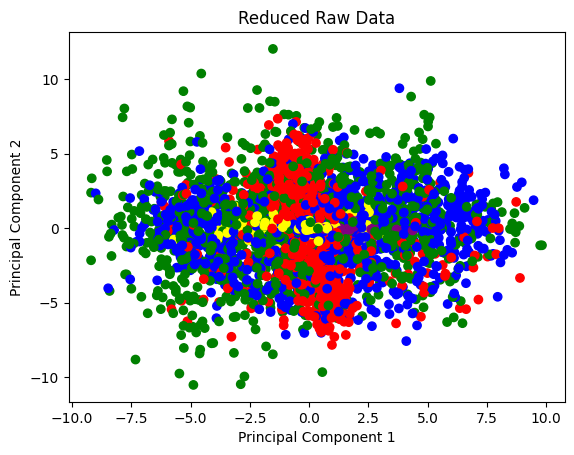

In [138]:
pca_raw = PCA(n_components=2)
pca.fit(X_raw)
X_raw_reduced = pca.transform(X_raw)

plt.scatter(X_raw_reduced[:, 0], X_raw_reduced[:, 1], c=colors)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Reduced Raw Data")
plt.show()